## Gerador de Reviews

In [9]:
import pandas as pd
import string
import pickle
import numpy as np
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

In [17]:
df = pd.read_csv('electronics.csv')
vc = df['overall'].value_counts()
m = 10_000 #vc.min()
df = pd.concat([df[df["overall"] == i].iloc[0:m] for i in vc.index])
df.loc[:,'overall'] = df['overall'].apply(int)
df.loc[:,'reviewText'] = df['reviewText'].apply(lambda x: str(x).replace('\\n','\n'))

In [93]:
df.to_csv('electronics10k.csv')

<AxesSubplot:>

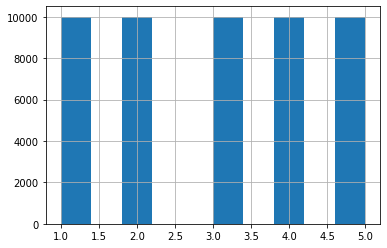

In [18]:
df["overall"].hist()

In [91]:
def clean_text(txt):
    # Regex obtida de https://www.geeksforgeeks.org/python-check-url-string/
    pattern = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    matcher = re.compile(pattern, re.VERBOSE)
    txt = matcher.sub("", txt)
    txt = re.sub(r"[\-\.,\?:;'\"/\\`~!@\\%\^&\*\(\)\[\]{}]", " ", txt)
    txt = re.sub("[«‹»›„“‟”’❝❞❮❯⹂〝〞〟＂‚‘‛❛❜❟]", " ", txt)
    txt = txt.lower()
    return txt

In [90]:
def small_sentences(txt: str):
    txt = txt.split()
    length = 5 + 1
    sentences = []
    for i in range(0, len(txt) - length):
        sentences.append(txt[i:i+length])
    return sentences

In [21]:
for overall in range(1,6):
    tokenizer = Tokenizer()
    sentences = (
        df["reviewText"][df["overall"] == overall]
        .apply(clean_text)
        .apply(small_sentences)
    )
    sentences.apply(tokenizer.fit_on_texts)
    sequences = sentences.apply(tokenizer.texts_to_sequences)
    sequences = sequences.apply(lambda x: np.array([np.array(y) for y in x]))
    sequences = sequences.loc[sequences.apply(lambda x: (len(x.shape)==2 and x.shape[1]==6))]
    vocab_size = len(tokenizer.word_index) + 1
    
    sequences = np.vstack(sequences.values)
    
    X, y = sequences[:,:-1], sequences[:,-1]
    y = to_categorical(y, num_classes=vocab_size)
    seq_length = X.shape[1]
    
#     model = Sequential()
#     model.add(Embedding(vocab_size, X.shape[1], input_length=X.shape[1]))
#     model.add(LSTM(100, return_sequences=True))
#     model.add(LSTM(100))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(vocab_size, activation = 'softmax'))
#     print(model.summary())
    
    break

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, X.shape[1], input_length=X.shape[1]))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation = 'softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 5)              87145     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 100)            42400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 17429)             1760329   
Total params: 1,990,474
Trainable params: 1,990,474
Non-trainable params: 0
____________________________________________

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X,y,batch_size=256, epochs = 20)

Epoch 1/20
393/393 [==============================] - 51s 120ms/step - loss: 5.5688 - accuracy: 0.1058
Epoch 2/20
393/393 [==============================] - 44s 113ms/step - loss: 5.4006 - accuracy: 0.1120
Epoch 3/20
393/393 [==============================] - 44s 112ms/step - loss: 5.2917 - accuracy: 0.1184
Epoch 4/20
393/393 [==============================] - 44s 111ms/step - loss: 5.1990 - accuracy: 0.1226
Epoch 5/20
393/393 [==============================] - 45s 115ms/step - loss: 5.1163 - accuracy: 0.1272
Epoch 6/20
393/393 [==============================] - 41s 105ms/step - loss: 5.0406 - accuracy: 0.1291
Epoch 7/20
393/393 [==============================] - 40s 101ms/step - loss: 4.9695 - accuracy: 0.1324
Epoch 8/20
393/393 [==============================] - 39s 100ms/step - loss: 4.9018 - accuracy: 0.1364
Epoch 9/20
393/393 [==============================] - 40s 102ms/step - loss: 4.8392 - accuracy: 0.1396
Epoch 10/20
393/393 [==============================] - 39s 100ms/step - l

In [84]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = []
    in_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        prediction = model.predict_classes(encoded, verbose=0)   
        txt = tokenizer.sequences_to_texts([prediction])[0]
        in_text += ' ' + txt
        result.append(txt)
    return ' '.join(result)

In [88]:
words = 100
seed_text = 'black laptop computer nook power'
generated = generate_seq(model, tokenizer, 5, seed_text, words)
print('\n'+ generated)


is a good idea to be thicker cleaners i have been able to get it to the same one i was astonished i could not buy this product i have to buy the same one pro the worst player i am going to use it back to a problem to get the same one and i have to buy the same one pro the worst player i am going to use it back to a problem to get the same one and i have to buy the same one pro the worst player i am going to use it back
